### Demo

Toy notebook to demonstate usage of Datasets

In [9]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd 
import json
import numpy as np
import matplotlib.patches as mpatches
import random
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from Datasets import BaseDataset



In [10]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resizing to smaller dimensions for quicker training
    transforms.ToTensor()  # Convert image to PyTorch tensor
])

dataset = BaseDataset('../data/', transform=transform)

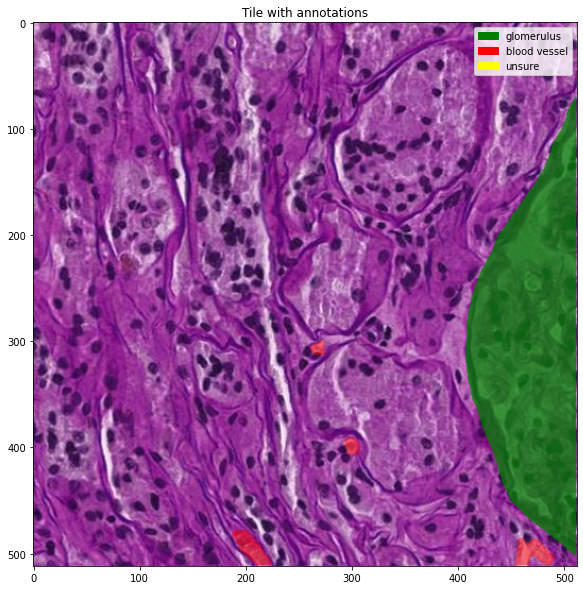

In [11]:
dataset.plot_base(5)

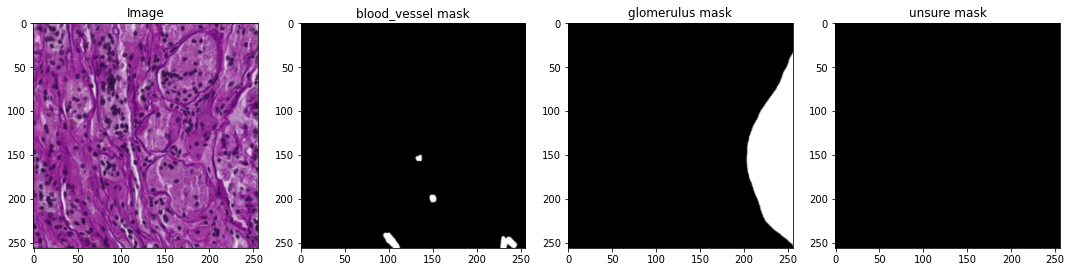

In [12]:
dataset.plot_example(5)

In [13]:
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [14]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Identity() 
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.init_conv = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, stride=1)

        self.encoder = nn.Sequential(
            ResidualBlock(16, 16),
            nn.MaxPool2d(2, stride=2),
            ResidualBlock(16, 32),
            nn.MaxPool2d(2, stride=2),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2, stride=2),
        )

        self.bottleneck = ResidualBlock(64, 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            ResidualBlock(128, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            ResidualBlock(64, 32),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ResidualBlock(32, 16),
        )

        self.out_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        x = self.init_conv(x)

        enc1 = self.encoder[0](x)
        enc2 = self.encoder[2](self.encoder[1](enc1))
        enc3 = self.encoder[4](self.encoder[3](enc2))

        bottleneck = self.bottleneck(self.encoder[5](enc3))

        dec1 = self.decoder[1](torch.cat([enc3, self.decoder[0](bottleneck)], dim=1))
        dec2 = self.decoder[3](torch.cat([enc2, self.decoder[2](dec1)], dim=1))
        dec3 = self.decoder[5](torch.cat([enc1, self.decoder[4](dec2)], dim=1))

        x = self.out_conv(dec3)

        return x

In [16]:
model = UNet(in_channels=3, out_channels=3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [17]:
num_epochs = 1
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
 
        optimizer.zero_grad()


        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1) 
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)
        
        running_loss += loss.item()
        

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / i)
    
    # Testing
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1) 
        correct += (predicted == labels).sum().item()
        total += torch.numel(labels)

        running_loss += loss.item()
    
    test_accuracy.append(100 * correct / total)
    test_loss.append(running_loss / i)


    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Train Acc: {train_accuracy[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_accuracy[-1]}")

Epoch 1, Train Loss: 0.09242277847671951, Train Acc: 58.6132779785904, Test Loss: 0.07131982576102018, Test Acc: 35.06456194303087
